In [1]:
import osmnx as ox
import networkx as nx
import pandas as pd
import geopandas as gpd
import numpy as np
import datashader as ds

import matplotlib.pyplot as plt

In [4]:
from pyrosm import OSM, get_data
osm = OSM(get_data("London"))

Downloaded Protobuf data 'London.osm.pbf' (92.01 MB) to:
'/var/folders/br/d_fg9g853bq1_bt73prjp3pr0000gn/T/pyrosm/London.osm.pbf'


In [5]:

pois = osm.get_pois(custom_filter={'amenity': True, "shop": True})

/Users/andrewrenninger/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/pyrosm/pois.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  gdf = prepare_geodataframe(
/Users/andrewrenninger/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/pyrosm/pois.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  gdf = prepare_geodataframe(
/Users/andrewrenninger/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/pyrosm/pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Sh

In [6]:
london = osm.get_data_by_custom_criteria(custom_filter= {"boundary": ["administrative"]})
london = london[london.name.str.contains("Greater London")]

<AxesSubplot:>

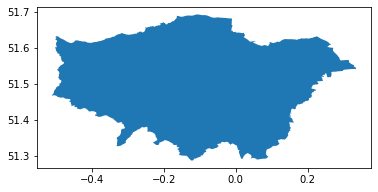

In [7]:
london.plot()

In [ ]:
G = ox.graph.graph_from_polygon(london.unary_union, network_type='drive')

In [ ]:
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

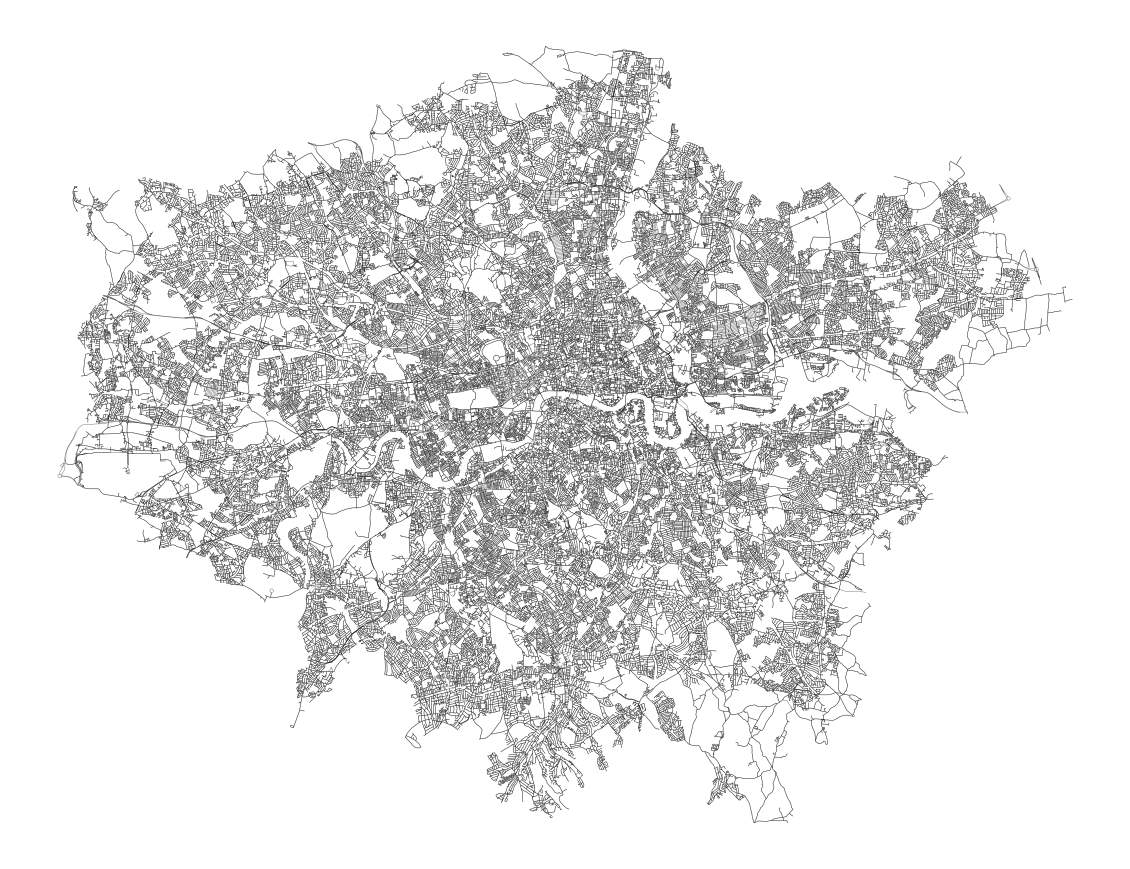

In [ ]:
ax = edges.plot(color='k', linewidth=0.5, alpha=0.5, figsize=(20, 20))
ax.set_axis_off()

In [ ]:
amenities = ox.geometries.geometries_from_polygon(london.unary_union, tags={'amenity': True})

/var/folders/br/d_fg9g853bq1_bt73prjp3pr0000gn/T/ipykernel_63690/4151780722.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ax = amenities.centroid.plot(color='k', markersize=0.5, alpha=0.5, figsize=(20, 20))


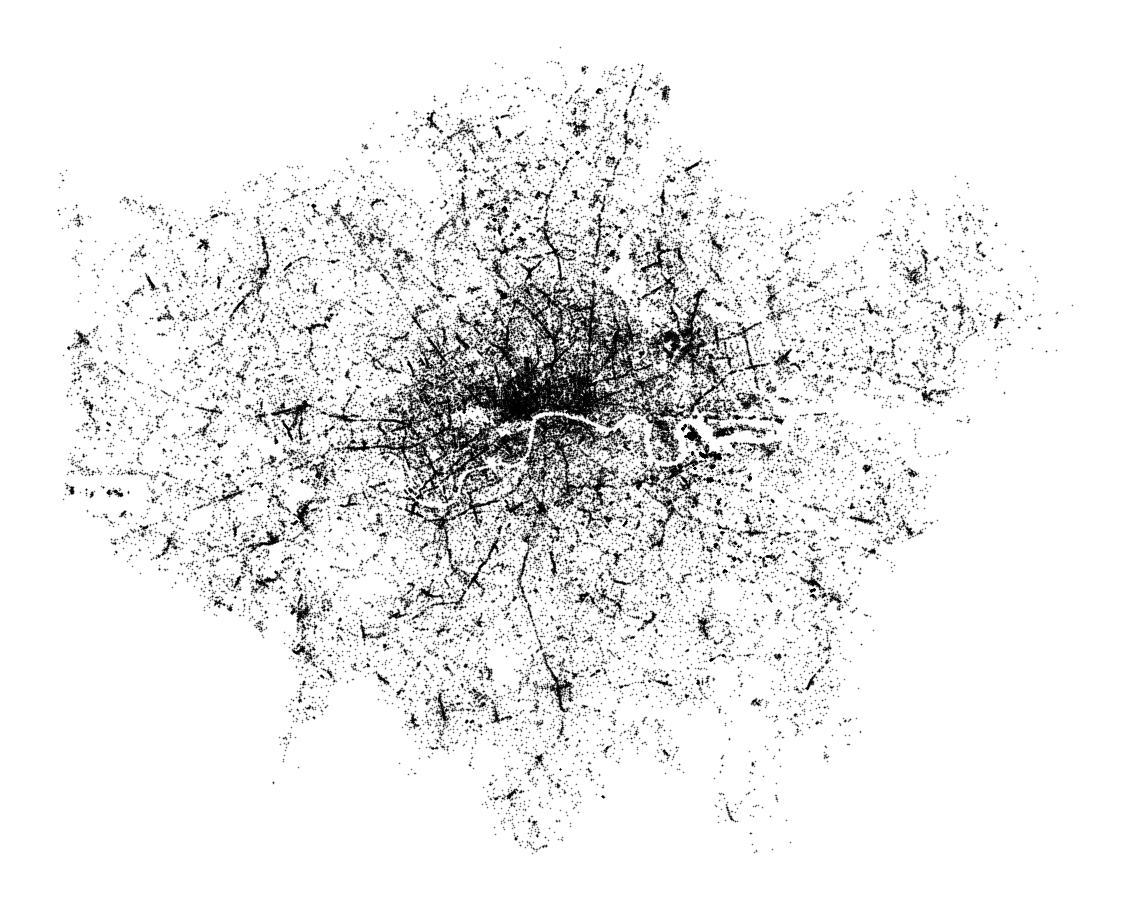

In [ ]:
ax = amenities.centroid.plot(color='k', markersize=0.5, alpha=0.5, figsize=(20, 20))
ax.set_axis_off()

/var/folders/br/d_fg9g853bq1_bt73prjp3pr0000gn/T/ipykernel_63690/2666767833.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ax = amenities[amenities.amenity.str.contains("restaurant")].centroid.plot(color='k', markersize=0.5, alpha=0.5, figsize=(20, 20))


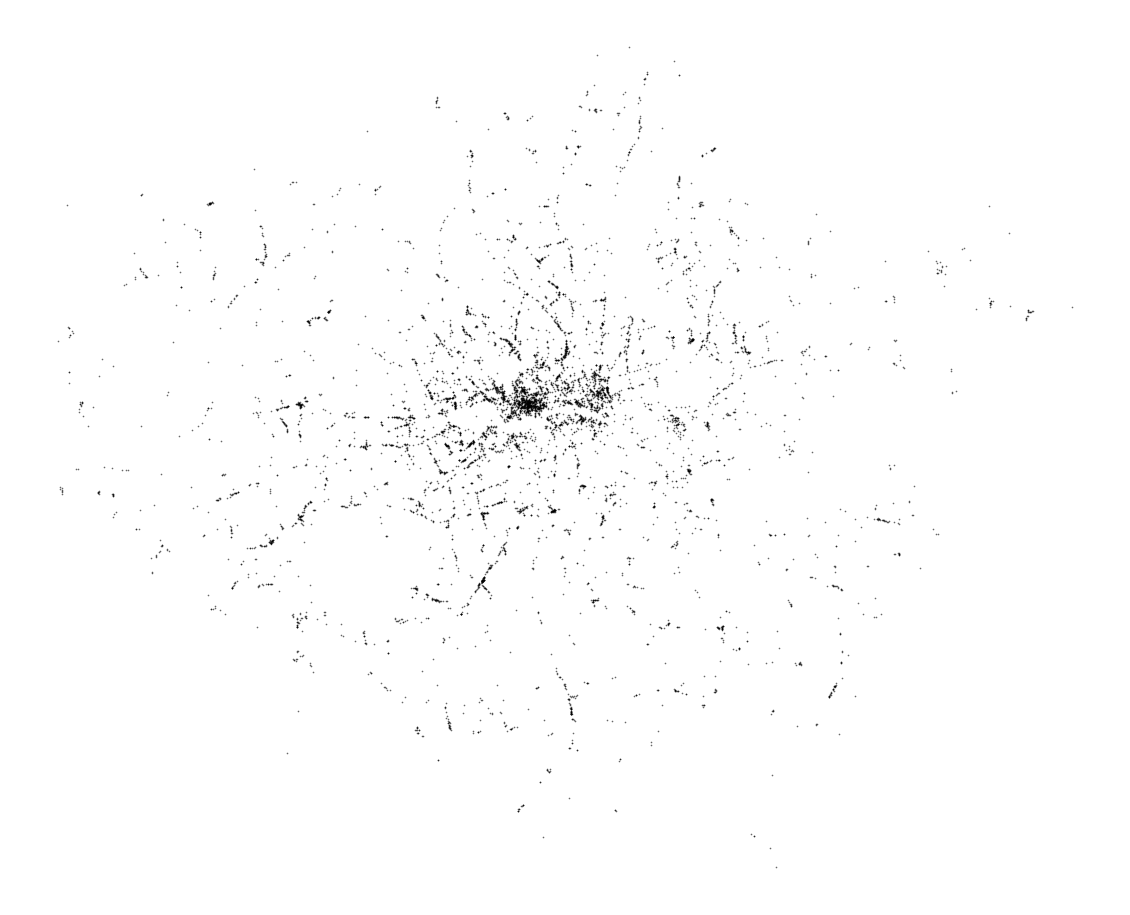

In [ ]:
ax = amenities[amenities.amenity.str.contains("restaurant")].centroid.plot(color='k', markersize=0.5, alpha=0.5, figsize=(20, 20))
ax.set_axis_off()

In [ ]:
parks = ox.geometries.geometries_from_polygon(london.unary_union, tags={'leisure': 'park'})

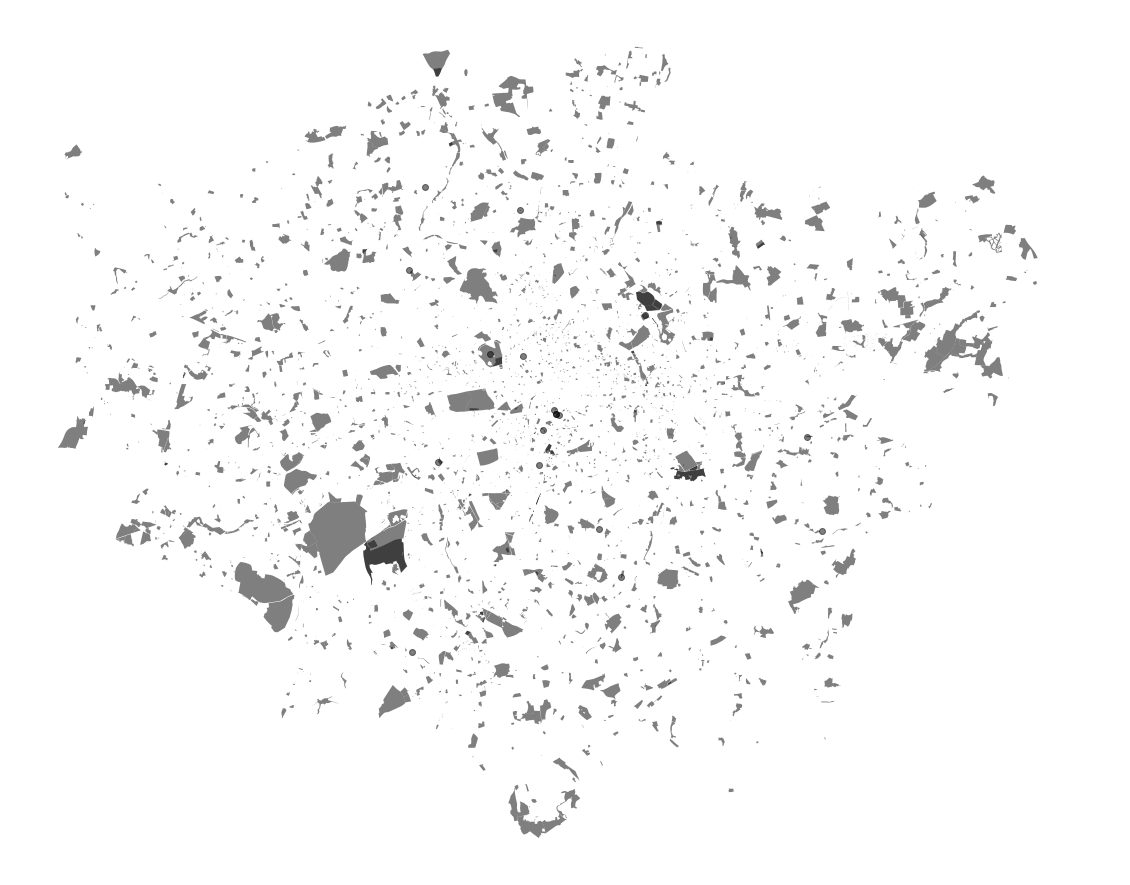

In [ ]:
ax = parks.plot(color='k', alpha=0.5, figsize=(20, 20))
ax.set_axis_off()

In [ ]:
cells = gpd.read_file("../data/cells.gpkg")

In [ ]:
pois = amenities[amenities.geometry.geom_type=="Point"].reset_index(drop=True)
pois = pois[['amenity', 'geometry']]
pois.to_crs(cells.crs, inplace=True)

In [ ]:
joined = pois.sjoin(cells, op='within').groupby('oa_code', as_index=False).count().sort_values('amenity', ascending=False)
joined = joined[['oa_code', 'amenity']].reset_index(drop=True)

/Users/andrewrenninger/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
cells = cells.merge(joined, left_on='oa_code', right_on='oa_code', how='left')
cells['amenity'] = cells['amenity'].fillna(0)

In [ ]:
restaurants = amenities[(amenities.amenity.str.contains("restaurant")) & (amenities.geometry.geom_type=="Point")].reset_index(drop=True)
restaurants = restaurants[['amenity', 'geometry']].rename(columns={'amenity': 'restaurant'})
restaurants.to_crs(cells.crs, inplace=True)

In [ ]:
joined = restaurants.sjoin(cells, op='within').groupby('oa_code', as_index=False).count().sort_values('amenity', ascending=False)
joined = joined[['oa_code', 'restaurant']].reset_index(drop=True)

/Users/andrewrenninger/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
cells = cells.merge(joined, left_on='oa_code', right_on='oa_code', how='left')
cells['restaurant'] = cells['restaurant'].fillna(0)

In [ ]:
conditions = [
    (cells["loac"]=='A'),
    (cells["loac"]=='B'),
    (cells["loac"]=='C'),
    (cells["loac"]=='D'),
    (cells["loac"]=='E'),
    (cells["loac"]=='F'),
    (cells["loac"]=='G'),
    (cells["loac"]=='H'),
]

choices = ["Intermediate Lifestyles", "High Density and High Rise Flats", "Settled Asians", "Urban Elites", "City Vibe", "London Life-Cycle", "Multi−Ethnic Suburbs", "Aging City Fringe"]


cells["loac"] = np.select(conditions, choices)
cells.head()

oa_code  population          loac  \
0  E00000001       250.0  Urban Elites   
1  E00000003       323.0  Urban Elites   
2  E00000005       143.0  Urban Elites   
3  E00000007       169.0  Urban Elites   
4  E00166756       240.0  Urban Elites   

                                            geometry  amenity  restaurant  
0  MULTIPOLYGON (((532303.492 181814.110, 532213....      2.0         0.0  
1  MULTIPOLYGON (((532180.131 181763.020, 532155....      0.0         0.0  
2  MULTIPOLYGON (((532124.321 181682.675, 532127....      1.0         0.0  
3  MULTIPOLYGON (((532124.321 181682.675, 532201....     23.0         2.0  
4  MULTIPOLYGON (((532162.491 181867.763, 532162....     14.0         0.0

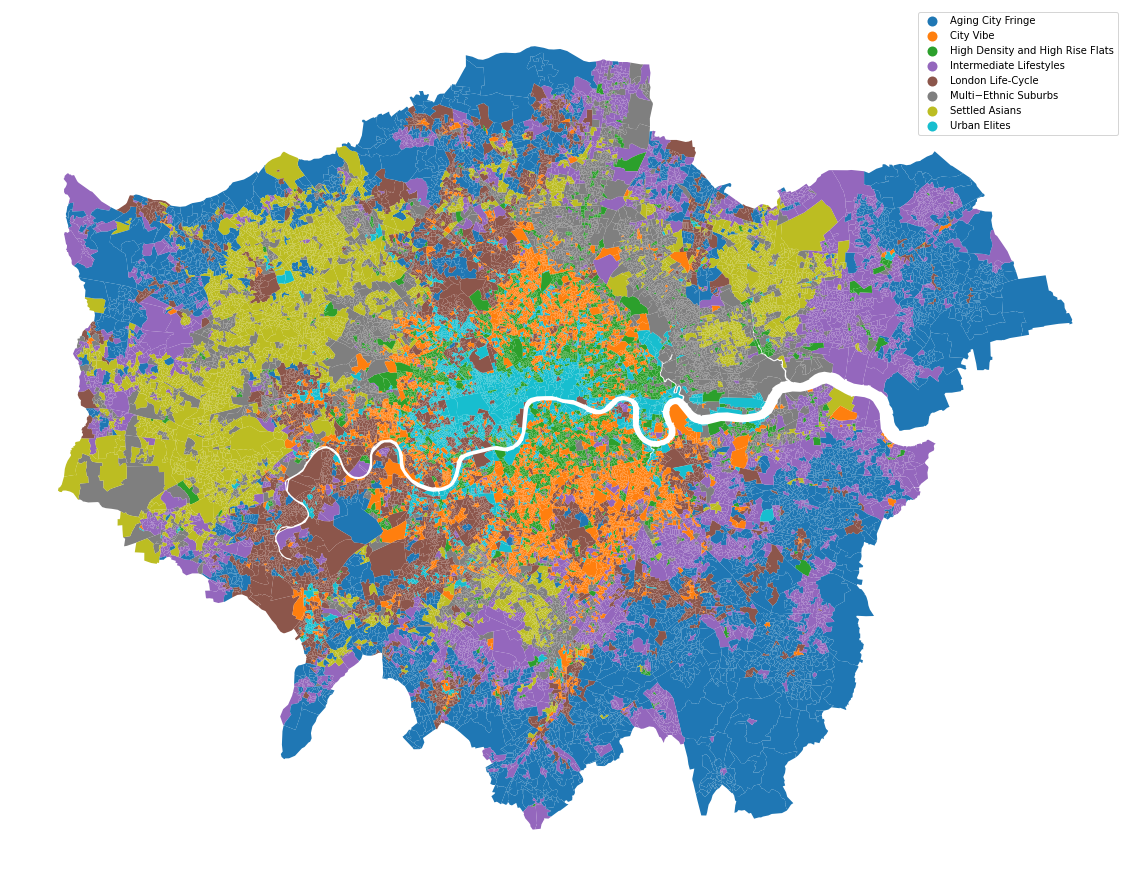

In [ ]:
ax = cells.plot(column='loac', categorical=True, legend=True, figsize=(20, 20))
ax.set_axis_off()

In [ ]:
cells[['oa_code', 'population', 'amenity', 'restaurant', 'loac']].to_csv("../data/cells.csv", index=False)

In [ ]:
cells = cells[['oa_code', 'population', 'amenity', 'restaurant', 'loac', 'geometry']]

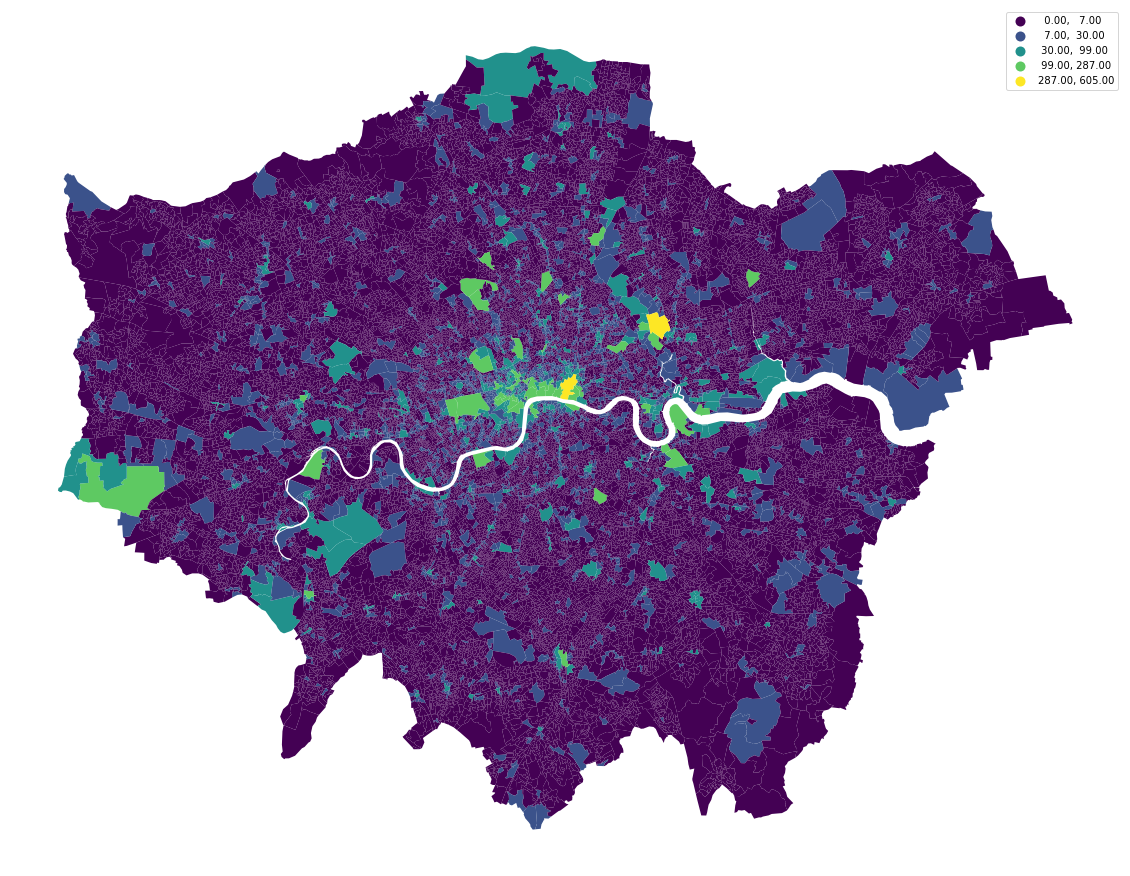

In [ ]:
ax = cells.plot(column='amenity',legend=True, scheme="natural_breaks", figsize=(20, 20))
ax.set_axis_off()

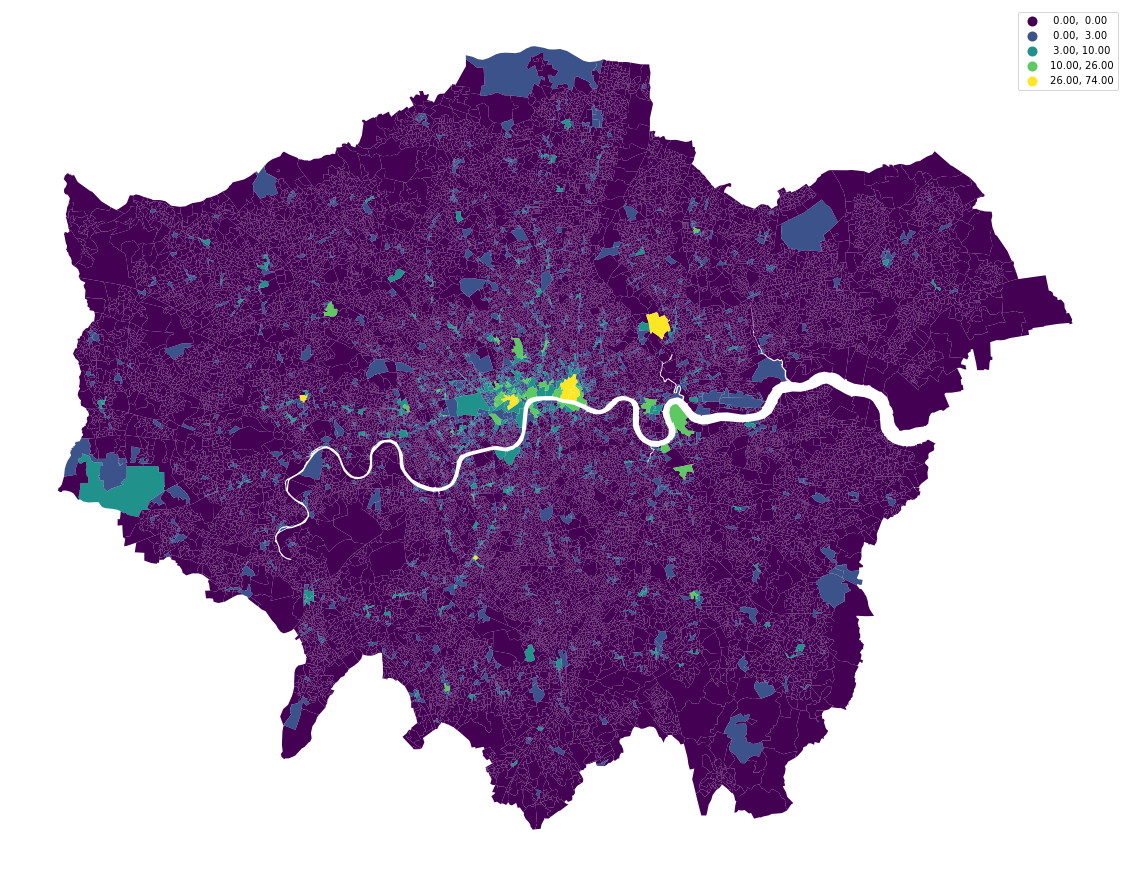

In [ ]:
ax = cells.plot(column='restaurant',legend=True, scheme="natural_breaks", figsize=(20, 20))
ax.set_axis_off()

In [ ]:
# get [x, y] coordinates for each polygon in a geodataframe
def get_xy_coords(gdf):
    gdf = gdf.copy()
    gdf['coords'] = gdf['geometry'].apply(lambda x: x.centroid.coords[:])
    gdf['coords'] = [coords[0] for coords in gdf['coords']]
    return gdf  

In [ ]:
get_xy_coords(cells)

oa_code  population  amenity  restaurant               loac  \
0      E00000001       250.0      2.0         0.0       Urban Elites   
1      E00000003       323.0      0.0         0.0       Urban Elites   
2      E00000005       143.0      1.0         0.0       Urban Elites   
3      E00000007       169.0     23.0         2.0       Urban Elites   
4      E00166756       240.0     14.0         0.0       Urban Elites   
...          ...         ...      ...         ...                ...   
25048  E00008169       232.0      3.0         0.0  London Life-Cycle   
25049  E00008171       255.0      0.0         0.0       Urban Elites   
25050  E00008174       278.0      0.0         0.0  London Life-Cycle   
25051  E00008178       258.0      1.0         0.0          City Vibe   
25052  E00008180       213.0      1.0         0.0  London Life-Cycle   

                                                geometry  \
0      MULTIPOLYGON (((532303.492 181814.110, 532213....   
1      MULTIPOLYGON (((532180.131 181763.020, 532155....   
2      MULTIPOLYGON (((532124.321 181682.675, 532127....   
3      MULTIPOLYGON (((532124.321 181682.675, 532201....   
4      MULTIPOLYGON (((532162.491 181867.763, 532162....   
...                                                  ...   
25048  MULTIPOLYGON (((538073.358 177007.835, 538085....   
25049  MULTIPOLYGON (((538057.489 177086.991, 538025....   
25050  MULTIPOLYGON (((537791.135 177011.399, 537836....   
25051  MULTIPOLYGON (((538073.358 177007.835, 538175....   
25052  MULTIPOLYGON (((538271.693 176903.977, 538192....   

                                        coords  
0      (532261.8239198235, 181865.33712505837)  
1      (532175.9984674867, 181826.08915727906)  
2      (532162.8640141943, 181728.66209645278)  
3      (532140.5131759215, 181478.39126086913)  
4      (532098.0275852715, 181814.69627088594)  
...                                        ...  
25048   (538131.2243468635, 177089.6275337232)  
25049   (537990.3459305657, 177150.4360930331)  
25050    (537929.0404722401, 177060.579577302)  
25051   (538094.8928489484, 176918.3554384664)  
25052   (538170.9151851072, 176870.0992560835)  

[25053 rows x 7 columns]

In [ ]:
pois

In [ ]:
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([m1, m2])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel(positions).T, X.shape)

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax.plot(m1, m2, 'k.', markersize=2)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.show()